# Final Project: **Regression Analysis of German Air Fares**
by **Andre Datchev**, **Hannah Kiel**, **Hannes Pohnke**, **Nikolas Jochens**

**Important!: You will need to change the import of the dataset to your local copy of it.**

## **Outline**
**1) Opening Remarks  
2) Data Loading & Sanitizing  
3) Data Analysis  
4) Data Preprocessing & Feature Engineering  
5) Evaluation Measures  
6) Linear Regression  
7) Polynomial (Ridge) Regression  
8) Extreme Gradient Boosting Regression  
9) Neural Network Regression  
10) Comparison of Models & Benchmarking  
11) Final Report<br>
12) Distribution of Work**

## **1) Opening Remarks**

We don't know exactly what kind of price configurations were chosen while scraping the dataset. We are assuming that each entry is the cheapest possible configuration for the corresponding flight. So no additional baggage, no extra leg room, no business class and no other extras that would influence the price.

## **2) Data Loading & Sanitizing**

### **2.1) Imports**

In [72]:
from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time as tm
from datetime import time
import datetime
import random
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **2.2) Dataset**
We will now import our dataset. It can be found under:  [*https://www.kaggle.com/datasets/darjand/domestic-german-air-fares*](https://www.kaggle.com/datasets/darjand/domestic-german-air-fares)<br>
We renamed the csv file to *german_air_fares.csv*. You need to download the dataset and change the location to your local copy yourself.

In [73]:
#original_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/german_air_fares.csv", sep=";")
data = pd.read_csv("german_air_fares.csv", sep=";")
data = original_data
data.head()
#data.info()
#data.describe()

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,stops,price (€)
0,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,2:40pm,3:50pm,Eurowings,direct,33.00
1,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,1:00pm,2:15pm,Eurowings,direct,33.00
2,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,8:45pm,10:00pm,Eurowings,direct,33.00
3,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,1:05pm,2:20pm,easyJet,direct,37.00
4,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,18.11.2019,1 month,5:30pm,6:45pm,easyJet,direct,37.00


### **2.3) Ambiguous Values**

Problem: "1 Stopp" and "1 stop" is the same, but in two different languages. We have the same problem with "Mehrere Fluglinien" and "Multiple Airlines".

In [74]:
# set initial data types
data = data.astype('string')

# rename price column
data = data.rename(columns={'price (€)': 'price'})

# fix price column format errors
data.price = data.price.str.replace(',', '', regex=True)
data.price = data.price.str.replace('.00', '', regex=True)

# rename entries in airlines column
data.airline = data.airline.str.replace('Mehrere Fluglinien', 'Multiple Airlines')

# rename entries in stops column
data.stops = data.stops.str.replace('direct', '0', regex=True)
data.stops = data.stops.str.replace('(1 Stopp)', '1', regex=True)
data.stops = data.stops.str.replace('(1 stop)', '1', regex=True)
data.stops = data.stops.str.replace('(2 Stopps)', '2', regex=True)

# rename entries in departure_date_distance
data.departure_date_distance = data.departure_date_distance.str.replace('2 weeks', '2 week', regex=True)
data.departure_date_distance = data.departure_date_distance.str.replace('2 week', '2 weeks', regex=True)
data.departure_date_distance = data.departure_date_distance.str.replace('3 months', '3 month', regex=True)
data.departure_date_distance = data.departure_date_distance.str.replace('3 month', '3 months', regex=True)

# Remove parentheses and convert to integers
data['stops'] = data['stops'].str.replace(r'[^0-9]', '', regex=True)

# rename entries in departure_time column
data.departure_time = data.departure_time.str.replace(' Uhr', '')


### **2.4) Missing Values**

In [75]:
# initially there is one erroneuos row, we can just drop it
#print(data['price'].unique())
data['price'] = pd.to_numeric(data['price'].replace('', pd.NA), errors='coerce') # there are also empty strings in the price column
sum_of_empty_prices = data.loc[data['price'].isna(), 'price'].sum()
print(sum_of_empty_prices)
print(data.isnull().sum())

data = data.dropna()
print(f"We just dropped {original_data.shape[0] - data.shape[0]} of {original_data.shape[0]} instances")

0.0
departure_city                1
arrival_city                  1
scrape_date                   1
departure_date                1
departure_date_distance       1
departure_time                1
arrival_time                  1
airline                       1
stops                         1
price                      1482
dtype: int64
We just dropped 1483 of 62627 instances


### **2.5) Data Types**


In [76]:
import re
# update data types
#print(f"Included scrape dates: {data['scrape_date'].unique()}") we might wanna do this for all columns in the beginning?
#print(data.loc[61443]) # to inspect a certain row

data = data.astype({'price': 'int32'})
data = data.astype({'stops': 'int32'})
data['scrape_date'] = pd.to_datetime(data['scrape_date'], format='%d.%m.%Y')
data['departure_date'] = pd.to_datetime(data['departure_date'], format='%d.%m.%Y')

#times have different formats: '2:40pm', '10:05'
def parse_time(time_str):
    match = re.match(r'(\d+):(\d+)([APMapm]*)', time_str)
    if match:
        hour, minute, period = match.groups()
        hour = int(hour)
        minute = int(minute)
        if 'p' in period.lower() and hour < 12:
            hour += 12
        return pd.Timestamp.combine(pd.Timestamp.today(), time(hour, minute)) # dont care about date, just time
    return pd.NaT

# Apply the custom function to 'departure_time' and 'arrival_time'
data['departure_time'] = data['departure_time'].apply(parse_time)
data['arrival_time'] = data['arrival_time'].apply(parse_time)


#data = data.astype({'scrape_date': 'datetime64[ns]'}) #warning, didn't run in anaconda environment but with basic python it does
#data = data.astype({'departure_date': 'datetime64[ns]'}) #warning
#data = data.astype({'departure_time': 'datetime64[ns]'}) #warning
print(data.isnull().sum())

departure_city             0
arrival_city               0
scrape_date                0
departure_date             0
departure_date_distance    0
departure_time             0
arrival_time               0
airline                    0
stops                      0
price                      0
dtype: int64


## **3) Analysis of Dataset**

### **3.1) General Overview**

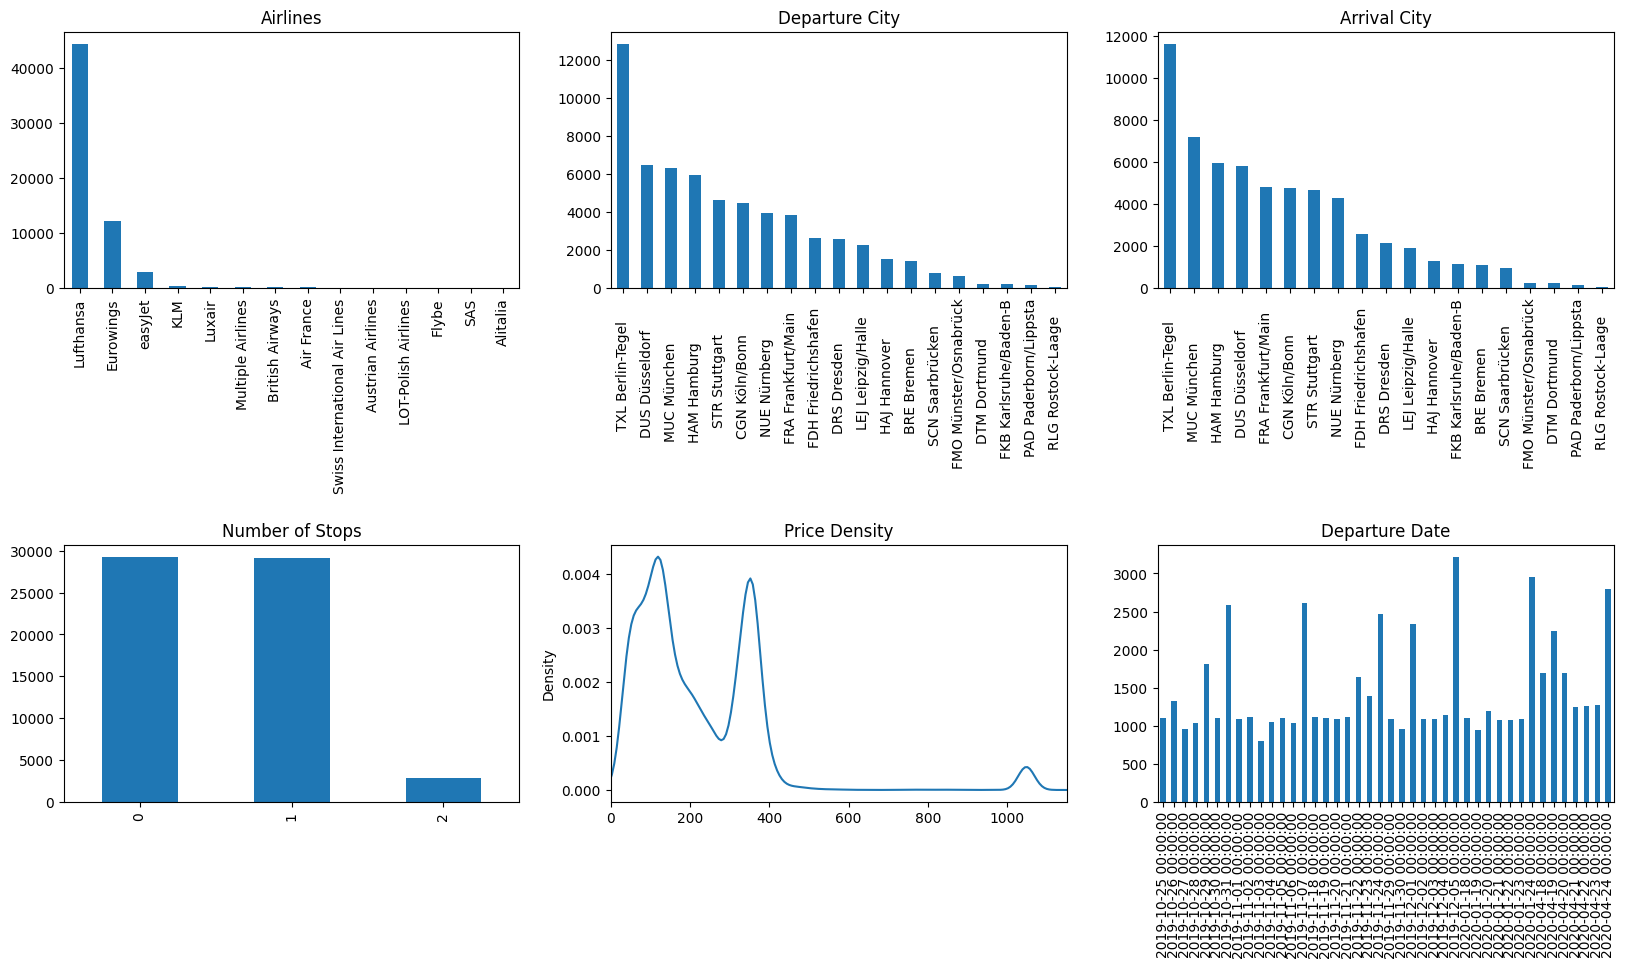

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

data.airline.value_counts().plot(ax=axes[0,0], kind="bar", xlabel="")
_ = axes[0,0].set_title('Airlines')

data.departure_city.value_counts().plot(ax=axes[0,1], kind="bar", xlabel="")
_ = axes[0,1].set_title('Departure City')

data.arrival_city.value_counts().plot(ax=axes[0,2], kind="bar", xlabel="")
_ = axes[0,2].set_title('Arrival City')

data.stops.value_counts().plot(ax=axes[1,0], kind="bar", xlabel="")
_ = axes[1,0].set_title('Number of Stops')

data.price.plot(ax=axes[1,1], kind="kde", xlabel="", xlim=(0,1150))
_ = axes[1,1].set_title('Price Density')

data.departure_date.value_counts().sort_index().plot(ax=axes[1,2], kind="bar", xlabel="")
_ = axes[1,2].set_title('Departure Date')

plt.subplots_adjust(hspace=1)

### **3.2) Median & Mean Price by Weekday, Month and Departure Date Distance**

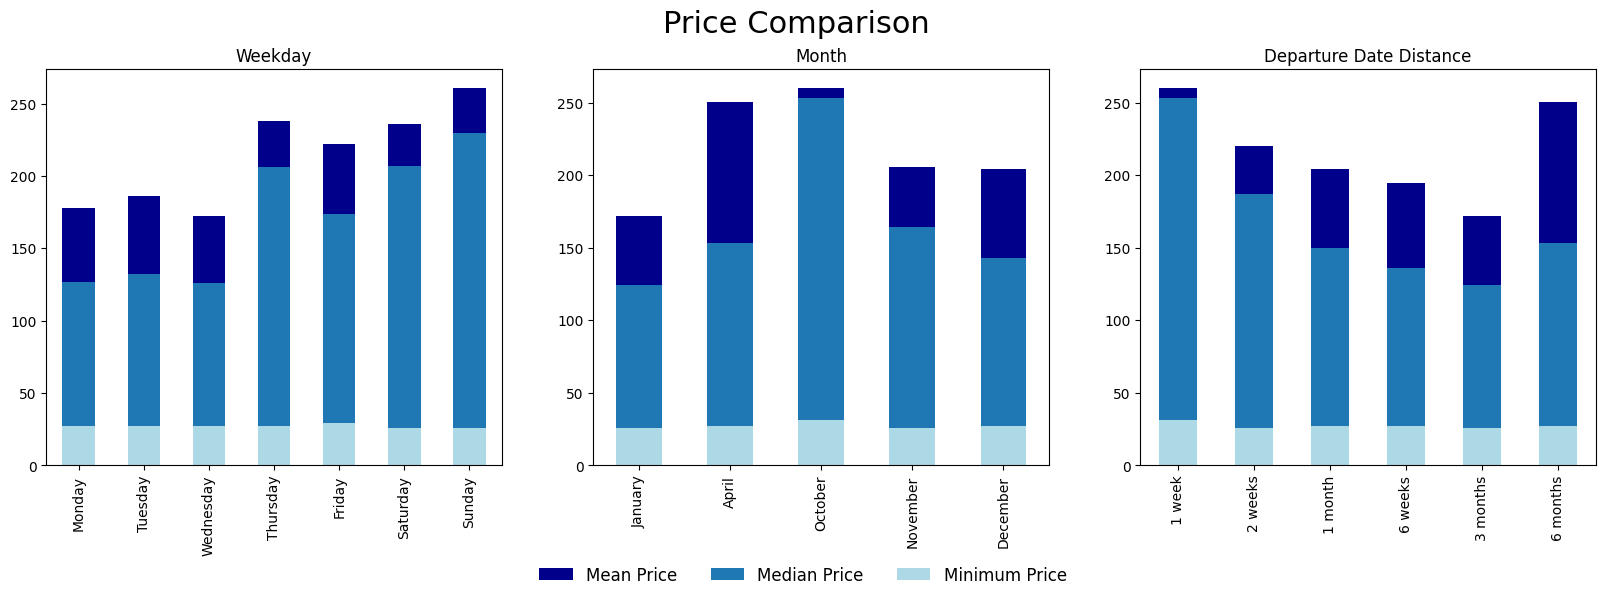

In [52]:
def print_price_distributions(dataset):

    # group by weekday & month & departure date distance
    grouped_weekday = dataset.groupby(dataset.departure_date.dt.day_name())
    grouped_month = dataset.groupby(dataset.departure_date.dt.month_name())
    grouped_departure_distance = dataset.groupby(dataset.departure_date_distance)

    # calculate mean and median prices
    weekday_mean_price = grouped_weekday.price.mean().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])
    weekday_median_price = grouped_weekday.price.median().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])
    weekday_min_price = grouped_weekday.price.min().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])

    month_mean_price = grouped_month.price.mean().reindex(["January","April","October","November","December"])
    month_median_price = grouped_month.price.median().reindex(["January","April","October","November","December"])
    month_min_price = grouped_month.price.min().reindex(["January","April","October","November","December"])

    departure_distance_mean_price = grouped_departure_distance.price.mean().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])
    departure_distance_median_price = grouped_departure_distance.price.median().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])
    departure_distance_min_price = grouped_departure_distance.price.min().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])

    # plot mean and median prices
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    plt.subplots_adjust(bottom=0.22)

    _ = weekday_mean_price.plot(ax=axes[0], xlabel="", kind="bar", color="darkblue")
    _ = weekday_median_price.plot(ax=axes[0], xlabel="", kind="bar")
    _ = weekday_min_price.plot(ax=axes[0], xlabel="", kind="bar", color="lightblue")
    _ = axes[0].set_title('Weekday')

    _ = month_mean_price.plot(ax=axes[1], xlabel="", kind="bar", color="darkblue")
    _ = month_median_price.plot(ax=axes[1], xlabel="", kind="bar")
    _ = month_min_price.plot(ax=axes[1], xlabel="", kind="bar", color="lightblue")
    _ = axes[1].set_title('Month')

    _ = departure_distance_mean_price.plot(ax=axes[2], xlabel="", kind="bar", color="darkblue")
    _ = departure_distance_median_price.plot(ax=axes[2], xlabel="", kind="bar")
    _ = departure_distance_min_price.plot(ax=axes[2], xlabel="", kind="bar", color="lightblue")
    _ = axes[2].set_title('Departure Date Distance')

    _ = fig.suptitle('Price Comparison', fontsize=22)
    _ = fig.legend(labels=["Mean Price", "Median Price", "Minimum Price"], loc="lower center", ncol=3, frameon=False, fontsize=12)

print_price_distributions(data)

## **4) Data Preprocessing & Feature Engineering**

The first part of data preprocessing has already been resolved from 2.2) - 2.5) in order to conduct the data analysis.

### **4.1) Feature Pruning**
We want to remove instances with rare feature values, that are not important for the regression, skew the data and increase the dimensionality. That some feature values are rare can be due to the inherent semantics of the data (e.g. no one flies 2 Stops in germany) or poor data collection.


In [53]:
#print(data['airline'].unique())
selected_airlines = ['Lufthansa', 'easyJet', 'Eurowings']

# As seen in the Data Analysis the many other airlines are just not represented enough to confidently use for our prediction
data_pruned = data[data['airline'].isin(selected_airlines)]

# The 2 Stop flights really scew our data, but dont seem to worsen the prediction so we just keep it
# data_pruned = data[data['stops'].isin([0, 1])]

print(f"We just dropped {data.shape[0] - data_pruned.shape[0]} of {data.shape[0]} instances")

We just dropped 1485 of 61144 instances


### **4.2) Feature Selection**
This should help to decrease the dimensionality of our problem, while increasing model performance.  
All the features we drop in this step can be dropped based on our understanding of the data.  
We will use a simple XGBoost model in a few steps to explore its feature_importance values and possibly create subsets of our data for comparison.

In [54]:
#we won't consider scrape date (it's dependent on departure_date_distance and departure_date)

X = data_pruned[['airline', 'stops', 'departure_city', 'arrival_city', 'departure_date', 'departure_date_distance', 'departure_time', 'arrival_time']]
label = data_pruned['price']
X.head()

,airline,stops,departure_city,arrival_city,departure_date,departure_date_distance,departure_time,arrival_time
0,Eurowings,0,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,1 month,2023-12-27 14:40:00,2023-12-27 15:50:00
1,Eurowings,0,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,1 month,2023-12-27 13:00:00,2023-12-27 14:15:00
2,Eurowings,0,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,1 month,2023-12-27 20:45:00,2023-12-27 22:00:00
3,easyJet,0,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,1 month,2023-12-27 13:05:00,2023-12-27 14:20:00
4,easyJet,0,TXL Berlin-Tegel,DUS Düsseldorf,2019-11-18,1 month,2023-12-27 17:30:00,2023-12-27 18:45:00


### **4.3) Encoding of categorical Features and Standardization**
Regressions need numbers!

In [55]:
# Encode categorical variables
oneHot = OneHotEncoder(drop='first', sparse_output=False) #drop first to cope with collinearity (a problem later on)
X_oneHot = oneHot.fit_transform(X[['departure_city', 'arrival_city', 'airline']])

X_oneHot = pd.DataFrame(X_oneHot, columns=oneHot.get_feature_names_out(['departure_city', 'arrival_city', 'airline']))
X = X.reset_index(drop=True) #nan prevention
X_oneHot = X_oneHot.reset_index(drop=True) #nan prevention
X = pd.concat([X, X_oneHot], axis=1)

X = X.drop(['departure_city', 'arrival_city', 'airline'], axis=1)

# Convert timespans into numeric values (we might wanna standardize or use one hot instead)
X['departure_date_distance'] = X['departure_date_distance'].map({
    '1 week': 7,
    '2 weeks': 14,
    '3 months': 90,
    '6 weeks': 42,
    '1 month': 30,
    '6 months': 180
})

# Split dates into their components (we might wanna standardize or use one hot instead)
X['departure_day_of_week'] = X['departure_date'].dt.dayofweek
X['departure_month'] = X['departure_date'].dt.month
X['departure_day_of_month'] = X['departure_date'].dt.day
X = X.drop(['departure_date'], axis=1)

# Get hour of arrival and departure time
X['departure_time'] = X['departure_time'].dt.hour
X['arrival_time'] = X['arrival_time'].dt.hour


#even though its a little unintuitive, we standardize the date/time features, because we got problems with ill conditioned matrices (large values) later on
#all of our models work better on scaled features
scaler = StandardScaler()
columns_to_scale = ['departure_date_distance', 'departure_day_of_month', 'departure_month', 'departure_day_of_week', 'departure_time', 'arrival_time']
X_to_scale = X[columns_to_scale]
X_scaled_columns = pd.DataFrame(scaler.fit_transform(X_to_scale), columns=columns_to_scale)
X = pd.concat([X.drop(columns=columns_to_scale), X_scaled_columns], axis=1)

y = label.values

print(f"Our Features to work with:")
X.head()

Our Features to work with:


,stops,departure_city_CGN Köln/Bonn,departure_city_DRS Dresden,departure_city_DTM Dortmund,departure_city_DUS Düsseldorf,departure_city_FDH Friedrichshafen,departure_city_FKB Karlsruhe/Baden-B,departure_city_FMO Münster/Osnabrück,departure_city_FRA Frankfurt/Main,departure_city_HAJ Hannover,...,arrival_city_STR Stuttgart,arrival_city_TXL Berlin-Tegel,airline_Lufthansa,airline_easyJet,departure_date_distance,departure_day_of_month,departure_month,departure_day_of_week,departure_time,arrival_time
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.566613,0.024892,0.720898,-1.651245,0.319418,-0.055040
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.566613,0.024892,0.720898,-1.651245,0.109777,-0.262628
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.566613,0.024892,0.720898,-1.651245,1.577265,1.398078
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.566613,0.024892,0.720898,-1.651245,0.109777,-0.262628
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.566613,0.024892,0.720898,-1.651245,0.948342,0.567725


### **4.4) Main Train/Test Split**
We use this main split on all of our remaining features.   
To quickly test our implementations we also create small batches of that set.

In [56]:
#X.values to get ndarrays for regression, might not wanna do this for other models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(type(X_train))

#Also create small batches (first 10% of data) to check implementations quickly
fraction = 0.1

X_train_small = X_train[:int(len(X_train) * fraction)]
y_train_small = y_train[:int(len(y_train) * fraction)]

X_test_small = X_test[:int(len(X_test) * fraction)]
y_test_small = y_test[:int(len(y_test) * fraction)]

<class 'pandas.core.frame.DataFrame'>


### **4.6) Feature Importance**
We use a simple XGBoost regression model to extract its feature importance values. We could also use this models performance for benchmarking purposes later on.

In [57]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = X_train, X_test, y_train, y_test

# Create an XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_reg.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

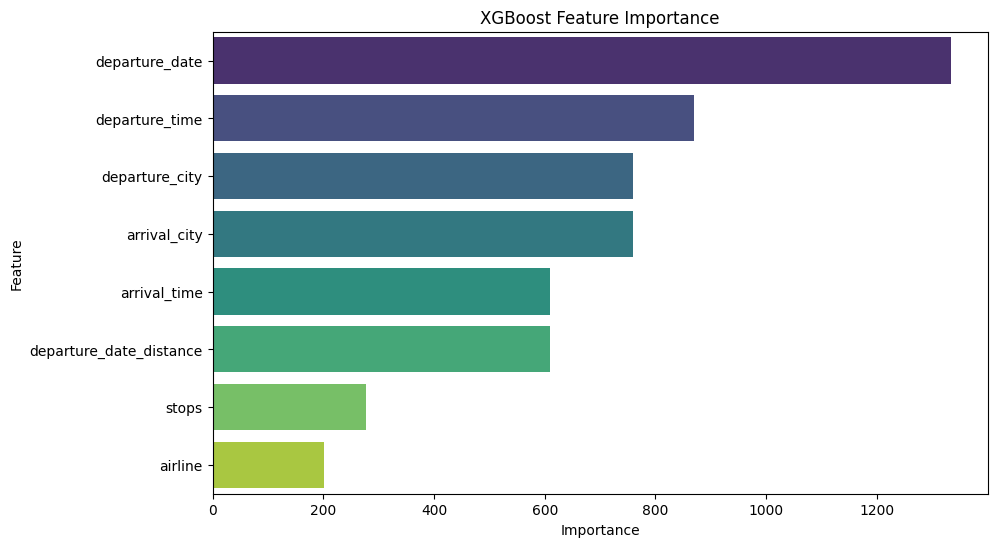

In [58]:
# Explore and plot feature importance
feature_importance = xgb_reg.get_booster().get_score(importance_type='weight')  # Get feature importance directly from the booster
feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)  # Sort by importance

# Aggregate importance scores for original features
original_feature_importance = {}
exclude_aggregation = {'departure_date_distance', 'departure_time', 'arrival_time'}

for encoded_feature, importance in feature_importance:
    # Check if the feature should be excluded from aggregation
    if encoded_feature in exclude_aggregation:
        original_feature_importance[encoded_feature] = importance
    else:
        # Aggregate features 'departure_day_of_week', 'departure_day_of_month', and 'departure_month' into 'departure_date'
        if 'departure_day_of_week' in encoded_feature or 'departure_day_of_month' in encoded_feature or 'departure_month' in encoded_feature:
            original_feature = 'departure_date'
        else:
            # Extract the original feature name by removing the part after the last underscore
            original_feature = encoded_feature.rsplit('_', 1)[0]

        original_feature_importance[original_feature] = original_feature_importance.get(original_feature, 0) + importance

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame(list(original_feature_importance.items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', palette='viridis', dodge=False)
plt.legend().set_visible(False)
plt.title('XGBoost Feature Importance')
plt.show()


### **4.7) Additional Splits**

Actually we were intending to just drop the time of the arrival and departure but its seemingly of very high importance. The XGB model for example has an MSE of about 1000 less when leaving out the time features.  

Split 2:
Just keeping departure_date, arrival_city, departure_city and departure_date_distance would have resembled a practical use case, because those are the parameters a customer would enter in order to book a flight. After testing this split against the main split, we got quicker run times but a way worse performance. So we didn't use this split further.

In [59]:
X2 = X.drop(['stops', 'airline_Lufthansa', 'airline_easyJet', 'departure_time', 'arrival_time'], axis=1)

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

#Also create small batches (first 10% of data) to check implementations quickly
fraction = 0.1

X2_train_small = X_train[:int(len(X_train) * fraction)]
X2_test_small = X_test[:int(len(X_test) * fraction)]

Split 3: Based on the feature importance values we will drop 'stops' and 'airlines' for this split. We do this in order to further decrease the complexity of our prediction and hopefully even improve our performance. This split is a little better than the second one but still much worse than the first split. It seems that for our Regression, the more information are available, the better the prediction gets.

In [60]:
X3 = X.drop(['stops', 'airline_Lufthansa', 'airline_easyJet'], axis=1)

X3_train, X3_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

#Also create small batches (first 10% of data) to check implementations quickly
fraction = 0.1

X3_train_small = X_train[:int(len(X_train) * fraction)]
X3_test_small = X_test[:int(len(X_test) * fraction)]


## **5) Evaluation Measures & Benchmark**

To compare the Quality of different Regression Models, we use the Mean Squared error:

$$MSE(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^n (\hat{y} - y^i)^2$$

with $\hat{y}$ being the price predictions we get from the Models and $y$ being the corresponding actual prices. Also addiotionally we will take the root of the MSE to get the Root Mean Squared Error. With this we will be able to compare our results to the benchmark paper.


$$RMSE(\hat{y}, y) = \sqrt{\frac{1}{n}\sum_{i=1}^n (\hat{y} - y^i)^2} = \sqrt{MSE}$$

About the benchmark paper: TODO

To Visualize the Quality of our predictions:

In [61]:
def plot_difference(predictions, y, title="Actual vs. Predicted Values"):
    plt.scatter(y, predictions)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)

    max_price = min(y.max(), predictions.max())
    min_price = max(y.min(), predictions.min())
    plt.plot([min_price, max_price], [min_price, max_price], 'r--')  # Red Line

    plt.show()

## **6) Linear Regression**

We will implement this whole model ourselves. A simple Linear regression with multiple modes for Gradient Descent and the Option to log the Error. Afterwards we compare it to the Linear Regression from sclearn

### **6.1) Hypothesis**
In the linear Regression we predict the price of a flight only knowing a set of input features $x$. We will do this with the hypothesis function $h_\theta(x)$ parameterized by the vector $\theta$.

$$    h_\theta(x) = \theta^Tx $$

In [62]:
def hypothesis(x, theta):
    h = np.dot(x, theta)
    return h

### **6.2 Training**

We will train our parameters $\theta$ with Gradient Descent according to the error function $J$.

$$J(\theta) = \frac{1}{2m}\sum_{i=1}^m (h_\theta(x^i) - y^i)^2$$

We implement three modes of Gradient Descent (GD). To be precise: batch GD, mini batch GD and stochastic GD. Now we are able to compare them in accuracy and speed. So for each iteration we will work on a subset $M \subset X$ of our complete training data with $|M| = m$. The subset size varies on the mode. For stochastic GD $m = 1$, for batch GD $m = |X|$ and for mini batch $m$ equals to a fraction of $|X|$. We update $\theta$ in each iteration according to the Gradient of the error Function.

$$\theta_j = \theta_j - \alpha \frac{\partial}{\partial \theta_j}J(\theta) = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^i) - y^i) \cdot x_j$$

We update all $\theta_j$ simultaneously

In [63]:
def compute_gradient(x_batch, theta, y_batch):
    h = hypothesis(x_batch, theta)
    error = h - y_batch
    return np.dot(x_batch.T, error) / len(x_batch)



def batch_gd(x, y, theta, lr):
    gradient = compute_gradient(x, theta, y)
    theta -= lr * gradient

    return theta

def mini_batch_gd(x, y, theta, lr, m, batch_size):

    for i in range(0, m, batch_size):
        x_batch = x[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        gradient = compute_gradient(x_batch, theta, y_batch)
        theta -= lr * gradient


    return theta

def stochastic_gd(x, y, theta, lr):

    for _ in range(len(x)):
        rand_index = random.randint(0,len(x)-1)
        x_sample = x[rand_index:rand_index+1]
        y_sample = y[rand_index:rand_index+1]
        gradient = compute_gradient(x_sample, theta, y_sample)

        theta -= lr * gradient

    return theta

In [64]:
def linear_regression(x, y, lr=0.01, epochs=1000, log_error=False, mode="stochastic", mini_batch_ratio=0.2, test_x=[], test_y=[]):
    x = np.c_[np.ones((x.shape[0], 1)), x]    #Add bias

    m, n = x.shape
    assert m == len(y), f"Dimension mismatch between x {m} and y {len(y)}"

    theta = np.random.rand(n)
    train_error_log = np.zeros(epochs + 1)
    test_error_log = np.zeros(epochs + 1)

    if log_error:

        if mode == "stochastic":
            for j in range(epochs):
                if j % int(epochs/10) == 0:
                    print("Epoch: ", j)
                    #print(theta[:6])
                h = hypothesis(x, theta)
                train_error_log[j] = mean_squared_error(h, y)
                test_error_log[j] = mean_squared_error(make_predictions(test_x, theta), test_y)

                theta = stochastic_gd(x, y, theta, lr)
        elif mode == "batch":
            for j in range(epochs):
                if j % int(epochs/10) == 0:
                    print("Epoch: ", j)
                    #print(theta[:6])
                h = hypothesis(x, theta)
                train_error_log[j] = mean_squared_error(h, y)
                test_error_log[j] = mean_squared_error(make_predictions(test_x, theta), test_y)

                theta = batch_gd(x, y, theta, lr,)
        elif mode == "mini_batch":
            for j in range(epochs):
                if j % int(epochs/10) == 0:
                    print("Epoch: ", j)
                    #print(theta[:6])
                h = hypothesis(x, theta)
                train_error_log[j] = mean_squared_error(h, y)
                test_error_log[j] = mean_squared_error(make_predictions(test_x, theta), test_y)

                theta = mini_batch_gd(x, y, theta, lr, m, int(mini_batch_ratio*m))
        else:
            print("mode given is not available")
    else:
        if mode == "stochastic":
            for j in range(epochs):
                if j % int(epochs/10) == 0:
                    print("Epoch: ", j)
                theta = stochastic_gd(x, y, theta, lr)
        elif mode == "batch":
            for j in range(epochs):
                if j % int(epochs/10) == 0:
                    print("Epoch: ", j)
                theta = batch_gd(x, y, theta, lr)
        elif mode == "mini_batch":
            for j in range(epochs):
                if j % int(epochs/10) == 0:
                    print("Epoch: ", j)
                theta = mini_batch_gd(x, y, theta, lr, m, int(mini_batch_ratio*m))
        else:
            print("mode given is not available")
    print("Finished all Epochs")

    h = hypothesis(x, theta)
    train_error_log[epochs] = mean_squared_error(h, y)
    test_error_log[epochs] = mean_squared_error(make_predictions(test_x, theta), test_y)

    return theta, train_error_log, test_error_log

#The hypothesis expect theta and x in the same direction
#This function checks if x has a bias and add one if not
def make_predictions(x, theta):
    a1, b1 = x.shape
    b2 = len(theta)

    if b1 == b2:
        return hypothesis(x, theta)
    elif b1 + 1 == b2:
        x_with_bias = np.c_[np.ones((x.shape[0], 1)), x]
        return hypothesis(x_with_bias, theta)
    else:
        raise Exception("Dimension Mismatch in make_predictions")

### **6.3 Testing**

In [65]:
#We use this part 6.4 testing to test our the functionality of our own implementations

#We will us this small set to test our functions and tune our hyper parameters
X_train_small_as_nd = X_train_small.values

theta_1, train_error_log_1, test_error_log_1 = linear_regression(X_train_small_as_nd, y_train_small, lr=0.01, epochs=50, log_error=True, test_x = X_test_small, test_y = y_test_small, mode="stochastic")

y_pred = make_predictions(X_test_small.values, theta_1)
mse_test_1 = mean_squared_error(y_pred, y_test_small)
mse_train_1 = mean_squared_error(make_predictions(X_train_small_as_nd, theta_1), y_train_small)

print(f"MSE for on the Training set: {mse_train_1}")
print(f"MSE for on the Test set: {mse_test_1}")

Epoch:  0
Epoch:  5
Epoch:  10
Epoch:  15
Epoch:  20
Epoch:  25
Epoch:  30
Epoch:  35
Epoch:  40
Epoch:  45
Finished all Epochs
MSE for on the Training set: 5909.611105864798
MSE for on the Test set: 8074.10629696467


### **6.5) Hyperparameters**

The Hyperparameters that we can tune are the folowing:


1.   Learning rate
2.   Number of epochs
3.   The size of the mini batches

And the learning rate being the most important we first set it.




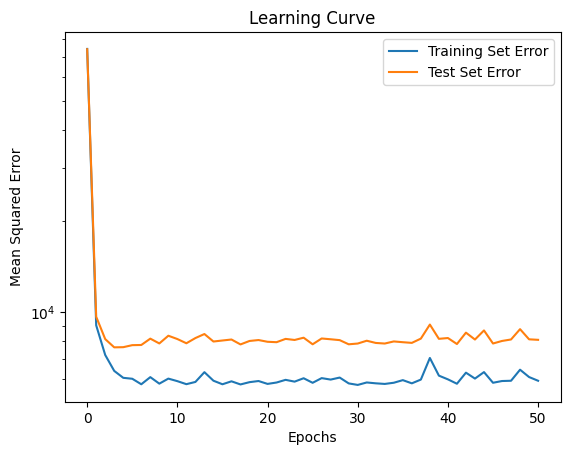

In [66]:
def plot_logging(logs, labels, title="Learning Curve"):
    assert len(logs) == len(labels), "Fallia"

    for i in range(len(logs)):
        plt.plot(range(len(logs[i])), logs[i], label=labels[i])

    plt.yscale('log')  # Set y-axis to logarithmic scale

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title(title)
    plt.show()

#Show the logs from 6.3 Testing as an example
plot_logging([train_error_log_1, test_error_log_1], ["Training Set Error", "Test Set Error"])



**How to set the learning rate**

We see above that the stochastic gradient descent had a few spikes in the Learning Curve. Those Spikes indicate an overshooting of a local minimum when updating $\theta$ by too much. This most probably happens when updating $\theta$ according to one of our data points that have much much higher pricing (See at the price density in 3. Analysis). For those data points the folowing term is very high: $h_\theta(x^i) - y^i$. The learning rate has to be low enough to prevent such overshooting but setting it too low means we will need more epochs and time to compute results. While the same term can get very high also for batch and mini batch gradient descent it is beeing evened out by $h_\theta(x^i) - y^i$ for the other $x_i$ in the same batch. Therefore we can increase the learning rate for those modes.

-------------------

**How to set the number of epochs**

After we decide for the learning rate we look to set the number of epochs. In theory with increasing number of epochs the error on the data should decrease until it converges. The problem is when we start overfitting on the data and the error on the test set start increasing again. Ideally we set our number of epochs such, that we stop right before this point.

In [67]:
time1 = tm.time()
theta_batch, train_error_log_batch, test_error_log_batch = linear_regression(X_train_small_as_nd, y_train_small, lr=0.5, epochs=500, log_error=True, mode="batch", test_x=X_test_small, test_y=y_test_small)
time2 = tm.time()
theta_mini_batch, train_error_log_mini_batch, test_error_log_mini_batch = linear_regression(X_train_small_as_nd, y_train_small, lr=0.1, epochs=40, log_error=True, mode="mini_batch", mini_batch_ratio = 0.02, test_x=X_test_small, test_y=y_test_small)
time3 = tm.time()
theta_stoc, train_error_log_stoc, test_error_log_stoc = linear_regression(X_train_small_as_nd, y_train_small, lr=0.0005, epochs=80, log_error=True, mode="stochastic", test_x=X_test_small, test_y=y_test_small)
time4 = tm.time()

y_pred_batch = make_predictions(X_test_small.values, theta_batch)
test_mse_batch = test_error_log_batch[-1]
#print(test_mse_batch," - ", mean_squared_error_our(y_pred_batch, y_test_small))
train_mse_batch = train_error_log_batch[-1]
#print(train_mse_batch," - ", mean_squared_error_our(make_predictions(X_train_small_as_nd, theta_batch), y_train_small))


y_pred_mini_batch = make_predictions(X_test_small.values, theta_mini_batch)
test_mse_mini_batch = test_error_log_mini_batch[-1]
#print(test_mse_mini_batch," - ", mean_squared_error_our(y_pred_mini_batch, y_test_small))
train_mse_mini_batch = train_error_log_mini_batch[-1]
#print(train_mse_mini_batch," - ", mean_squared_error_our(make_predictions(X_train_small_as_nd, theta_mini_batch), y_train_small))


y_pred_stoc = make_predictions(X_test_small.values, theta_stoc)
test_mse_stoc = test_error_log_stoc[-1]
train_mse_stoc = train_error_log_stoc[-1]

Epoch:  0
Epoch:  50
Epoch:  100
Epoch:  150
Epoch:  200
Epoch:  250
Epoch:  300
Epoch:  350
Epoch:  400
Epoch:  450
Finished all Epochs
Epoch:  0
Epoch:  4
Epoch:  8
Epoch:  12
Epoch:  16
Epoch:  20
Epoch:  24
Epoch:  28
Epoch:  32
Epoch:  36
Finished all Epochs
Epoch:  0
Epoch:  8
Epoch:  16
Epoch:  24
Epoch:  32
Epoch:  40
Epoch:  48
Epoch:  56
Epoch:  64
Epoch:  72
Finished all Epochs


To set the Number of Epochs we want to see at what point the MSE doesnt decrease for the test Set:

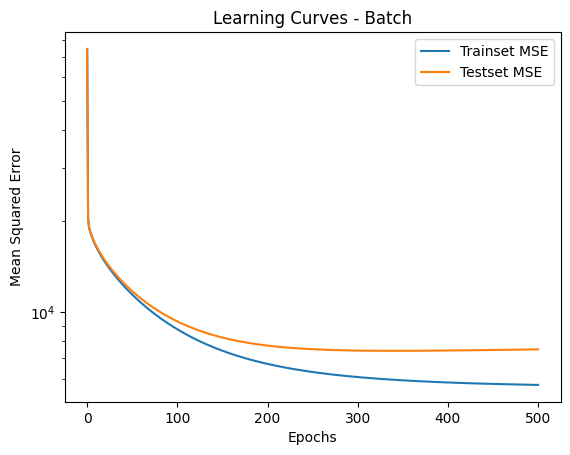

With Batch GD: The MSE on the train set is: 5716.7450445013 and on the test set: 7499.677984013907


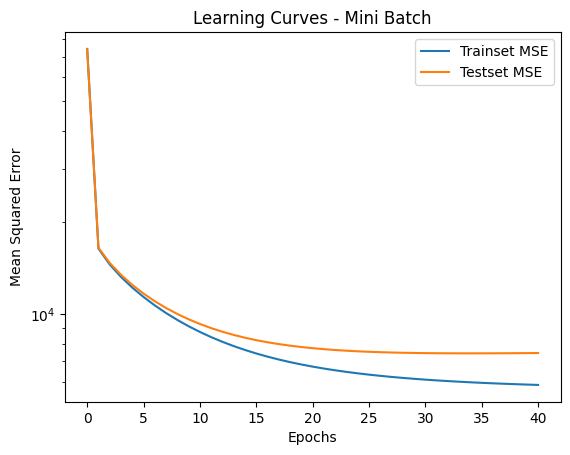

With Mini Batch GD: The MSE on the train set is: 5850.435623145879 and on the test set: 7446.059813915929


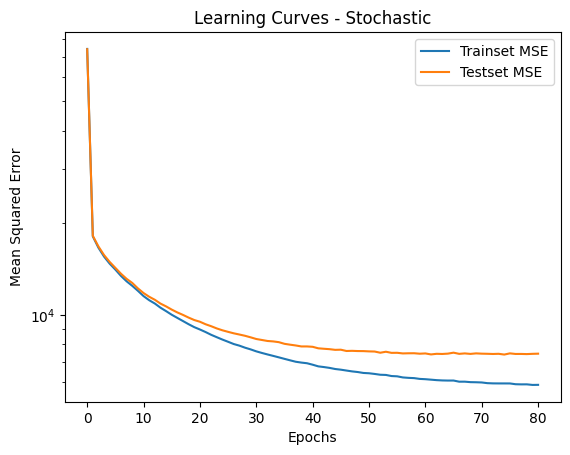

With Stochastic GD: The MSE on the train set is: 5885.798611087942 and on the test set: 7445.73234670148


In [68]:
plot_logging([train_error_log_batch, test_error_log_batch],["Trainset MSE", "Testset MSE"], "Learning Curves - Batch")
print(f"With Batch GD: The MSE on the train set is: {train_mse_batch} and on the test set: {test_mse_batch}")
plot_logging([train_error_log_mini_batch, test_error_log_mini_batch],["Trainset MSE", "Testset MSE"], "Learning Curves - Mini Batch")
print(f"With Mini Batch GD: The MSE on the train set is: {train_mse_mini_batch} and on the test set: {test_mse_mini_batch}")
plot_logging([train_error_log_stoc, test_error_log_stoc],["Trainset MSE", "Testset MSE"], "Learning Curves - Stochastic")
print(f"With Stochastic GD: The MSE on the train set is: {train_mse_stoc} and on the test set: {test_mse_stoc}")

After some tries we decided on the following parameters:

|mode|learning rate| epochs|
|--------|-------|-----|
|Batch| 0.5 | 500 |
|Mini Batch| 0.1 | 40 |
|Stochastic| 0.0005 | 80 |

### **6.6) Linear sklearn Regression**


In [69]:
# Fit a regression model
lin_reg_sk = LinearRegression()
time_sk1 = tm.time()
lin_reg_sk.fit(X_train_small, y_train_small)
time_sk2 = tm.time()
# Make predictions on the training set
y_train_pred = lin_reg_sk.predict(X_train_small)
train_error_lin_sk = mean_squared_error(y_train_small, y_train_pred)

# Make predictions on the test set
y_test_pred = lin_reg_sk.predict(X_test_small)
test_error_lin_sk = mean_squared_error(y_test_pred, y_test_small)

### **6.7) Linear Regression Comparison**


In [ ]:
print(f"For batch Gradient Descent the execution time was {(time2 - time1):.4f} and the MSE is {test_mse_batch}")
print(f"For mini batch Gradient Descent the execution time was {(time3 - time2):.4f} and the MSE is {test_mse_mini_batch}")
print(f"For stochastic Gradient Descent the execution time was {(time4 - time3):.4f} and the MSE is {test_mse_stoc}")
print(f"For the SkLearn implementation the execution time was {(time_sk2 - time_sk1):.4f} and the MSE is {test_error_lin_sk}")

For batch Gradient Descent the execution time was 3.7678 and the MSE is 7499.839370371354
For mini batch Gradient Descent the execution time was 0.3685 and the MSE is 7446.609859151497
For stochastic Gradient Descent the execution time was 8.9163 and the MSE is 7400.578718078737
For the SkLearn implementation the execution time was 0.0734 and the MSE is 7759.190224035542


In the end all of our implemented modes reach similiar errors. The main difference in choosing a mode is the execution time. The mini batch was the fastest and stochastic gradient descent was the slowest. And the time difference is actually very huge, with a factor of ca. 25x. The Sklearn impementation was a lot faster but has an accuracy thats a little bit worse.

The reason stochastic gradient descent is so much slower lies in the nature of our data set. To even out any spike in the learning curve we had to set the learning rate very low. With it beeing that low the stochastic mode needs more epochs than mini batch even though the mini batch update theta far fewer times per epoch than stochastic mode.

In Conclusion the best Version is our implemented and tuned mini batch gradient descent, being faster than our other implementations and more accurate than the SkLearn version.

### **6.8) Best Linear Regression Model on the whole dataset**


Epoch:  0
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  90
Finished all Epochs
We have a MSE of: 6206.535208206238 and a RMSE of: 78.78156642391822


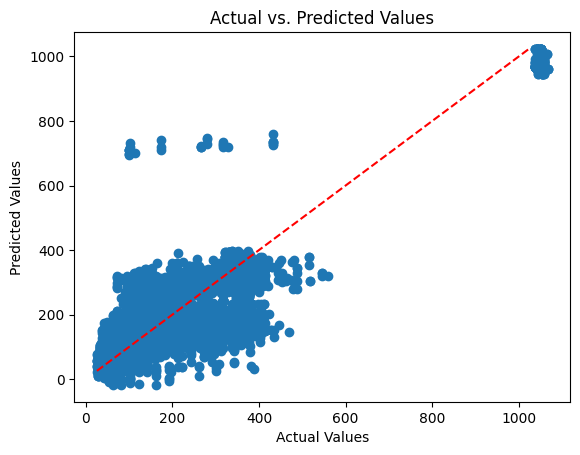

In [ ]:
theta, test_error_log_lin, train_error_log_lin = linear_regression(X_train.values, y_train, lr=0.05, epochs=100, log_error=True, mode="mini_batch", mini_batch_ratio = 0.02, test_x=X_test, test_y=y_test)

y_pred_lin = make_predictions(X_test, theta)
error_lin = train_error_log_lin[-1]
rmse_lin = mean_squared_error(y_pred_lin, y_test, squared=False)

print(f"We have a MSE of: {error_lin} and a RMSE of: {rmse_lin}")
plot_difference(y_pred_lin, y_test)
#plot_logging([test_error_log_lin, train_error_log_lin], ["test", "train"], title="Our implemented Linear regression on the whole data set")


## **7) Polynomial (Ridge) Regression**

Because of limited RAM, none of the code below was running on our colab environment, when using the full dataset.  
We had to execute this part locally and still had problems with higher degrees. For that reason we only consider the polynomials 1 to 3.  

### **7.1 Fit the initial Regression Models**

We have to regularize the polynomial regression, because the simple regression from the previous step overfits heavily.

In [ ]:
xtr, xte, ytr, yte = X_train, X_test, y_train, y_test
#xtr, xte, ytr, yte = X2_train, X2_test, y_train, y_test
#xtr, xte, ytr, yte = X3_train, X3_test, y_train, y_test
#xtr, xte, ytr, yte = X_train_small, X_test_small, y_train_small, y_test_small
#xtr, xte, ytr, yte = X2_train_small, X2_test_small, y_train_small, y_test_small

degrees = np.arange(1, 4)
train_errors_ridge = []
test_errors_ridge = []

for degree in degrees:
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(xtr)
    X_test_poly = poly_features.transform(xte)

    # Fit a regression model
    ridge_reg_sk = Ridge(alpha=1) #0.5 is result after tuning, but just a minimal performance difference
    # Regularization, since the normal regression overfits heavily
    # We also have a problem with collinearity - we dropped the first value of each one hot encoding and standardized to cope with that
    ridge_reg_sk.fit(X_train_poly, ytr)

    # Make predictions on the training set
    y_train_pred = ridge_reg_sk.predict(X_train_poly)
    train_error = mean_squared_error(ytr, y_train_pred)
    train_errors_ridge.append(train_error)

    # Make predictions on the test set
    y_test_pred = ridge_reg_sk.predict(X_test_poly)
    test_error = mean_squared_error(yte, y_test_pred)
    test_errors_ridge.append(test_error)


### **7.2 Performance vs Polynomial Degree**

In [ ]:
# Display the errors
print("Train errors:", train_errors_ridge)
print("Test errors:", test_errors_ridge)

# Plot the errors
plt.plot(degrees, train_errors_ridge, label='Train Error', marker='o')
plt.plot(degrees, test_errors_ridge, label='Test Error', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance vs. Polynomial Degree')
plt.legend()
plt.show()

### **7.3 Hyperparameter Tuning**

I tried using GridSearchCV, but it was too ressource expensive for our environment. Terefore we have no Cross Validation for the tuning process here. Seemingly the standard Ridge alpha value is already well suited for our regression, because the tuning process didn't add significant performance.

In [ ]:
xtr, xte, ytr, yte = X_train, X_test, y_train, y_test
#xtr, xte, ytr, yte = X2_train, X2_test, y_train, y_test
#xtr, xte, ytr, yte = X3_train, X3_test, y_train, y_test
#xtr, xte, ytr, yte = X_train_small, X_test_small, y_train_small, y_test_small
#xtr, xte, ytr, yte = X2_train_small, X2_test_small, y_train_small, y_test_small # surprisingly this doesnt really affect the results

degrees = np.arange(1, 4)
alpha_values = [0.5, 1, 10] # i tried more alphas, but its impossible to run through more values at a time for me

ridge_best_alpha = None
ridge_best_degree = None
ridge_best_test_error = float('inf')
ridge_best_train_predictions = None
ridge_best_test_predictions = None

for degree in degrees:
    for alpha in alpha_values:
        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly_features.fit_transform(xtr)
        X_test_poly = poly_features.transform(xte)

        # Fit a regression model
        ridge_reg_sk = Ridge(alpha=alpha)
        # Regularization, since the normal regression overfits heavily
        # We also have a problem with collinearity - we dropped the first value of each one hot encoding and standardized to cope with that
        ridge_reg_sk.fit(X_train_poly, ytr)

        # Make predictions on the test set
        ridge_y_test_pred = ridge_reg_sk.predict(X_test_poly)
        ridge_test_error = mean_squared_error(yte, ridge_y_test_pred)

        # If this model has a lower test error, update the best parameters
        if ridge_test_error < ridge_best_test_error:
            ridge_best_alpha = alpha
            ridge_best_degree = degree
            ridge_best_test_error = ridge_test_error
            ridge_best_train_predictions = ridge_reg_sk.predict(X_train_poly)
            ridge_best_test_predictions = ridge_y_test_pred

# Now you have the best_alpha, best_degree, best_test_error, best_train_predictions, and best_test_predictions
# You can use them for further analysis or save the results as needed
print("Best Alpha:", ridge_best_alpha)
print("Best Degree:", ridge_best_degree)
print("Best Test Error:", ridge_best_test_error)



### **7.4 Best Model Performance**

I'm pretty confident that we could have achieved an even better performance for the polynomial regression if I would have been able to compute degrees higher than 3. Unfortunately that is not the case. Even the current code for 7.3) was not executable on our colab environment, so I had to do it locally.

In [ ]:
plot_difference(ridge_best_test_predictions, y_test_small)

## **8) Extreme Gradient Boosting Regression**

We already defined a XGBoost model. Let's see how it performs.

In [ ]:
# Make predictions on the test set
y_test_pred_xgb = xgb_reg.predict(X_test)
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)

# Print or save the MSE values
print("XGB MSE on Test Set:", mse_test_xgb)

XGB MSE on Test Set: 1713.742245230795


As we were researching for similiar projects and a benchmark for our regression, we found out that tree based models tend to do pretty well for this problem. Thatswhy we added this model to our project, even though we didn't plan to do so from the start. While we are at it let's hyperparameter tune this and safe the model for comparison.

Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Tuned XGB MSE on Test Set: 1222.709472655905


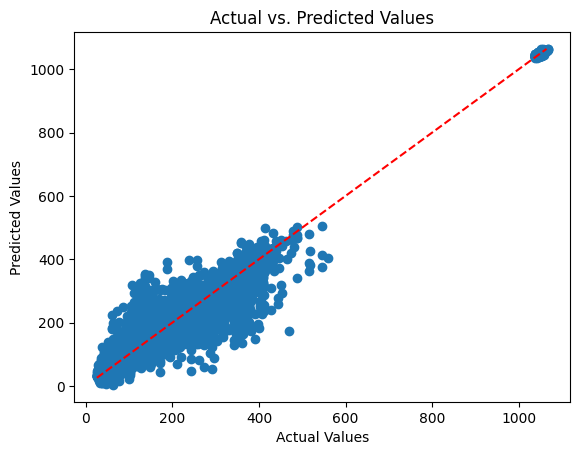

In [ ]:
# Define the parameter grid for random search
param_dist = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [5, 6, 7, 8],
    #'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [200, 500, 1000],
    #'gamma': [0, 0.1, 0.2],
    #'reg_alpha': [0, 0.1, 0.5],
    #'reg_lambda': [1, 2, 5]
}

# Create an XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_reg, param_distributions=param_dist, n_iter=15, scoring='neg_mean_squared_error', random_state=42
)

# Perform the random search on the training data
random_search.fit(X_train_xgb, y_train_xgb)

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Use the best model to make predictions on the test set
y_test_pred_xgb_tuned = random_search.best_estimator_.predict(X_test)

# Calculate the MSE on the test set
mse_test_xgb_tuned = mean_squared_error(y_test, y_test_pred_xgb_tuned)

# Print or save the MSE values
print("Tuned XGB MSE on Test Set:", mse_test_xgb_tuned)
plot_difference(y_test_pred_xgb_tuned, y_test)

## **9) Neural Network Regression**

We developed three neural networks. The first was a basic linear model ('model1'). Next, ('model2') added depth with two hidden layers. Finally, ('model3') introduced more layers and dropout regularization for enhanced performance.

**Model 1**


*   Architecture: Single-layer neural network with a linear activation function.
*   Input Layer: Input layer with a number of neurons equal to the number of features in the training data
*Activation Function: Linear activation function, which means it performs linear regression
*Loss Function: Mean squared error used for training, common for regression tasks
*Optimizer: Adam optimizer used for updating model weights during training
*Training: Trained for 10 epochs with a batch size of 32


In [ ]:
model1 = Sequential([
    Dense(1, input_shape=(X_train.shape[1],), activation='linear')
])

model1.compile(optimizer='adam', loss='mean_squared_error')

model1.fit(X_train, y_train, epochs=10, batch_size=32)

loss = model1.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

Epoch 1/10
1492/1492 [==============================] - 3s 2ms/step - loss: 74688.8828
Epoch 2/10
1492/1492 [==============================] - 2s 2ms/step - loss: 71995.8047
Epoch 3/10
1492/1492 [==============================] - 3s 2ms/step - loss: 69395.3516
Epoch 4/10
1492/1492 [==============================] - 4s 2ms/step - loss: 66878.5938
Epoch 5/10
1492/1492 [==============================] - 2s 2ms/step - loss: 64434.9805
Epoch 6/10
1492/1492 [==============================] - 2s 1ms/step - loss: 62067.4453
Epoch 7/10
1492/1492 [==============================] - 2s 2ms/step - loss: 59774.9570
Epoch 8/10
1492/1492 [==============================] - 2s 2ms/step - loss: 57557.1172
Epoch 9/10
1492/1492 [==============================] - 3s 2ms/step - loss: 55411.0547
Epoch 10/10
373/373 [==============================] - 3s 5ms/step - loss: 51023.3945
Test loss: 51023.39453125


**Model 2**

* Architecture: Neural network with three layers
*Input Layer: Input layer with a number of neurons equal to the number of features in the training data
*Hidden Layers: Two hidden layers, each with 64 neurons and ReLU activation functions
*Output Layer: Output layer with a single neuron
*Activation Function: ReLU activation function used in the hidden layers
*Loss Function: Mean squared error used for training
*Optimizer: Adam optimizer used for updating model weights during training.
*Training: The model is trained for 10 epochs with a batch size of 32, meaning it goes through the entire training dataset 10 times, updating its weights in each epoch


In [ ]:
model2 = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mean_squared_error')

model2.fit(X_train, y_train, epochs=10, batch_size=32)

loss = model2.evaluate(X_test, y_test)
print(f"Test loss: {loss}")


Epoch 1/10
1492/1492 [==============================] - 6s 3ms/step - loss: 17038.4863
Epoch 2/10
1492/1492 [==============================] - 4s 3ms/step - loss: 4650.4746
Epoch 3/10
1492/1492 [==============================] - 4s 3ms/step - loss: 3964.4773
Epoch 4/10
1492/1492 [==============================] - 3s 2ms/step - loss: 3620.9385
Epoch 5/10
1492/1492 [==============================] - 3s 2ms/step - loss: 3415.2332
Epoch 6/10
1492/1492 [==============================] - 3s 2ms/step - loss: 3272.4768
Epoch 7/10
1492/1492 [==============================] - 3s 2ms/step - loss: 3172.0691
Epoch 8/10
1492/1492 [==============================] - 4s 3ms/step - loss: 3089.2344
Epoch 9/10
1492/1492 [==============================] - 3s 2ms/step - loss: 3026.4875
Epoch 10/10
373/373 [==============================] - 1s 1ms/step - loss: 2989.5693
Test loss: 2989.5693359375


**Model 3**

*   Architecture: Neural network with
multiple layers
* Input Layer: Input layer with a number of neurons equal to the number of features in the training data.
* Hidden Layers: Three hidden layers with 128, 64, and 32 neurons, respectively. Each hidden layer uses the ReLU activation function to introduce non-linearity
*Dropout Layers: Two dropout layers with a dropout rate of 0.3, inserted after the first and second hidden layers
Output Layer: Output layer with a single neuron
*Activation Function: ReLU activation function used in the hidden layers.
Loss Function: Mean squared error used for training
*Optimizer: Adam optimizer used for updating model weights during training
*Training: The model is trained for 40 epochs with a batch size of 32





In [ ]:
# X_train and X_test conversion to dense format
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

model3 = Sequential([
    InputLayer(input_shape=(X_train_dense.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model3.compile(optimizer='adam', loss='mean_squared_error')

model3.fit(X_train_dense, y_train, epochs=40, batch_size=32, validation_split=0.2)

loss = model3.evaluate(X_test_dense, y_test)
print(f"Test loss: {loss}")

Epoch 1/40
1194/1194 [==============================] - 5s 3ms/step - loss: 13606.7930 - val_loss: 4637.0435
Epoch 2/40
1194/1194 [==============================] - 5s 4ms/step - loss: 5143.4009 - val_loss: 4039.7498
Epoch 3/40
1194/1194 [==============================] - 3s 3ms/step - loss: 4738.0698 - val_loss: 3711.7415
Epoch 4/40
1194/1194 [==============================] - 3s 3ms/step - loss: 4523.4858 - val_loss: 3632.6213
Epoch 5/40
1194/1194 [==============================] - 3s 3ms/step - loss: 4422.8442 - val_loss: 3480.4395
Epoch 6/40
1194/1194 [==============================] - 4s 4ms/step - loss: 4327.4146 - val_loss: 3402.2432
Epoch 7/40
1194/1194 [==============================] - 4s 3ms/step - loss: 4233.5679 - val_loss: 3448.6880
Epoch 8/40
1194/1194 [==============================] - 3s 2ms/step - loss: 4213.7881 - val_loss: 3512.4358
Epoch 9/40
1194/1194 [==============================] - 3s 3ms/step - loss: 4151.7910 - val_loss: 3370.1816
Epoch 10/40
1194/1194 [====

**Prediction:**
Prediction of the first 100 examples. Comparing them with actual prices.

**Performance Metrics:**
It calculates Mean Absolute Error and R² Score to measure model accuracy and goodness of fit.

**Visualization:**
The code creates a scatter plot to visually assess the relationship between predicted and actual prices.

373/373 [==============================] - 1s 3ms/step
Predicted Price: 207.64015197753906, Actual Price: 74
Predicted Price: 289.3385314941406, Actual Price: 376
Predicted Price: 97.82688903808594, Actual Price: 112
Predicted Price: 355.3694763183594, Actual Price: 364
Predicted Price: 127.25086212158203, Actual Price: 131
Predicted Price: 82.90191650390625, Actual Price: 75
Predicted Price: 37.841941833496094, Actual Price: 48
Predicted Price: 218.94200134277344, Actual Price: 247
Predicted Price: 132.62713623046875, Actual Price: 155
Predicted Price: 293.2618103027344, Actual Price: 377
Predicted Price: 167.49391174316406, Actual Price: 292
Predicted Price: 155.58201599121094, Actual Price: 155
Predicted Price: 375.2289733886719, Actual Price: 359
Predicted Price: 131.0433349609375, Actual Price: 120
Predicted Price: 157.2725067138672, Actual Price: 174
Predicted Price: 262.872314453125, Actual Price: 362
Predicted Price: 56.86790084838867, Actual Price: 50
Predicted Price: 244.9985

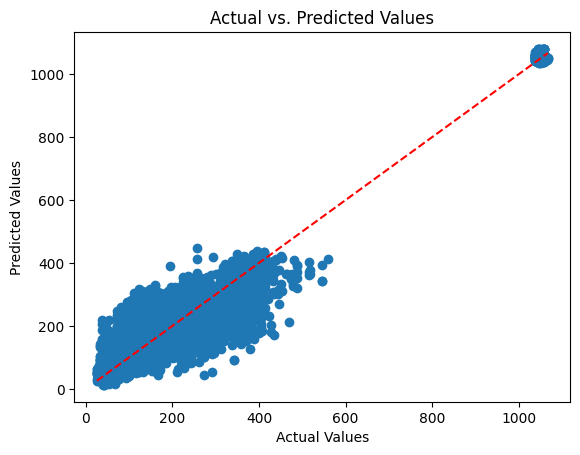

In [ ]:
# CHOOSE YOUR MODEL
predictions = model2.predict(X_test)

#25 predicted vs. actual
for i in range(25):
    print(f"Predicted Price: {predictions[i][0]}, Actual Price: {y_test[i]}")

# MAE, MSE and R2
error_nn = mean_squared_error(predictions, y_test)
rmse_nn = mean_squared_error(predictions, y_test, squared=False)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error (MSE): {error_nn}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn}")
print(f"R² Score: {r2:.2f}")

# Visualization predictions
plot_difference(predictions, y_test)

Model 1:

Mean Squared Error: 51031.30
Root Mean Squared Error: 225.90
R² Score: -0.79

Model 2:

Mean Squared Error: 2966.12
Root Mean Squared Error: 54.46
R² Score: 0.90

Model 3:

Mean Squared Error: 3374.48
Root Mean Squared Error (RMSE): 58.09
R² Score: 0.88


Model 2 performs the best among the three models, having the lowest MSE and RMSE values, and the highest R² score. It is the complex architecture with multiple layers and ReLU activations.
Model 3, despite having dropout layers for regularization, has slightly higher MSE and RMSE compared to Model 2.
Model 1 performs the worst, with a negative R² score. It is not a suitable model for the data, but it is just included to show the first ideas.

Let's safe the best NN for Comparison:

In [ ]:
best_nn = model2
best_nn_predictions = model2.predict(X_test)
best_nn_mse = mean_squared_error(predictions, y_test)

## **10) Comparison of Models and Benchmarking**

We will now proceed to compare the models we created and tested in the sections above. We start by introducing a benchmark we will compare our model implementations against.

### **10.1 Benchmark**

To have some kind of basis for the evaluation of our models we used the performance values obtained for similar models from the paper [**A Framework for Airfare Price Prediction: A Machine Learning Approach**](https://www.researchgate.net/publication/335936877_A_Framework_for_Airfare_Price_Prediction_A_Machine_Learning_Approach) by researchers of the *Florida International University*. The papers models are created on the bases of the publicly available datasets DB1B and T-100. Similar to our approach the data is first preprocessed with a following feature extraction and selection. The processed data is then used to train and evaluate the following models:
- Linear Regression
- Support Vector Machine
- Multilayer Perceptron Neural Network
- XGBoost
- Random Forests




### **10.2 Model Comparison**


Our performance results, as well as the applicable ones from the before mentioned paper are visualised in the figure below.

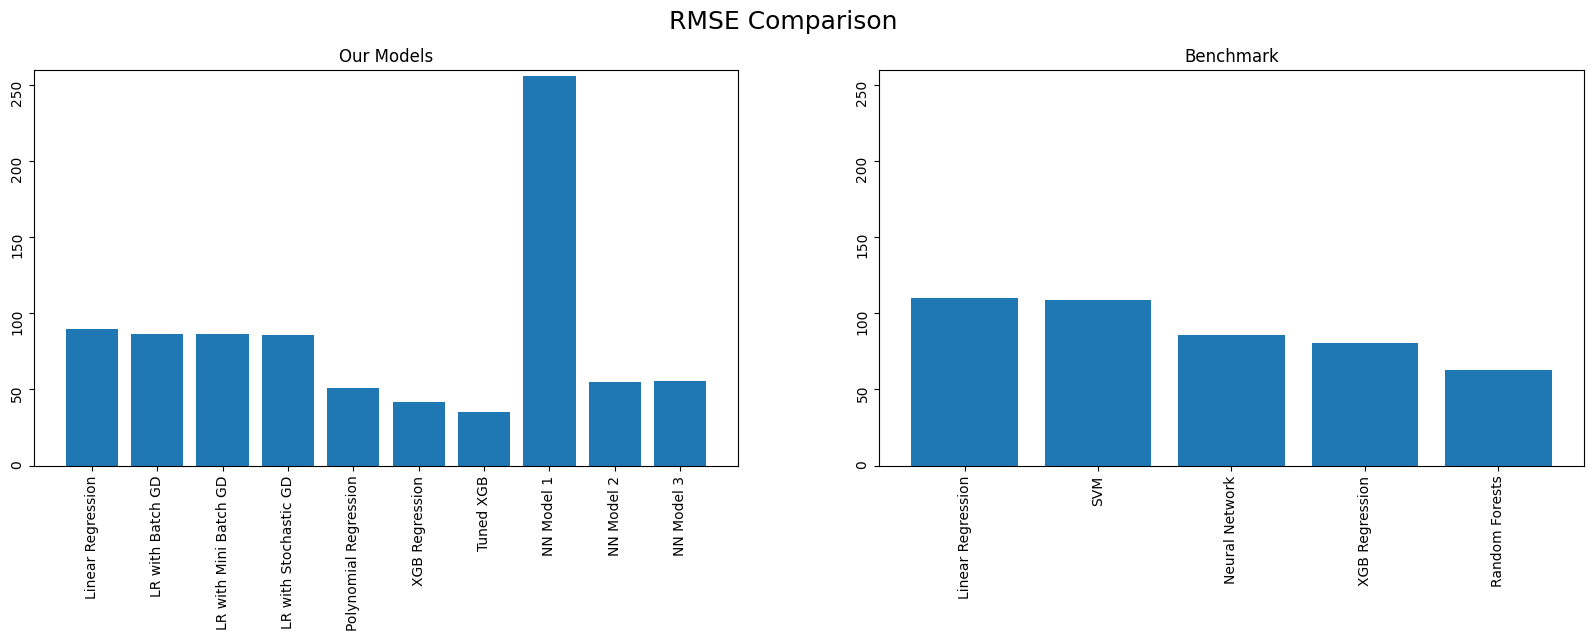

In [ ]:
labels = ["Linear Regression", "LR with Batch GD", "LR with Mini Batch GD", "LR with Stochastic GD", "Polynomial Regression", "XGB Regression", "Tuned XGB", "NN Model 1", "NN Model 2", "NN Model 3"]
values = [89.7, 86.6, 86.3, 86, 50.8, 41.4, 35, 255.9, 54.7, 55.6]
benchmark_labels = ["Linear Regression", "SVM", "Neural Network", "XGB Regression", "Random Forests"]
benchmark = [110.3, 108.4, 85.8, 80.4, 62.8]


import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
plt.subplots_adjust(bottom=0.22)
axes[0].bar(labels, values)
axes[0].tick_params(labelrotation=90)
axes[0].set_title('Our Models')
axes[0].set_ylim(0, 260)
axes[1].bar(benchmark_labels, benchmark)
axes[1].tick_params(labelrotation=90)
axes[1].set_title('Benchmark')
axes[1].set_ylim(0, 260)
_ = fig.suptitle('RMSE Comparison', fontsize=18)


Our best model was the tuned version of the XGBoost regression, followed by polynomial regression and the closely after by the 2nd and 3rd model of our neural network implementation. The linear regression models came in last with a significant distance to the others. Our 1st neural network model was so poorly designed, that we would exclude it from the official evaluation.<br>

The benchmark results are overall a fair bit less accurate compared to our results. This can be explained by the very different scope of the datasets used. Our dataset contained a significantly smaller portion of flights, as it only included domestic flights in Germany during a very specific timeframe. Suprisingly to us the benchmark paper, as well as the paper mentioned in 'further research' both use very different featues than we do, which is probably also a factor in the discrepancy in performance. In fact we might just have better features to predict the price.<br>

Nonetheless we can observe the same performance increase with the different model types used. When excluding random forests and SVM, the best performing model of the benchmark is also XGBoost regression, followed by the neural network and then the linear regression.

### **10.3 Our Best Model: XGBoost Regression**

Below you can find a chart of XGBoosts performance in predicting the actual air fare prices. The x axes gives the actual price and the y axes the predicted price. The closer the values are to the diagonal, the better the model performs. As you can observe we have not a lot of outliers and none that are really big outliers. The model overall performs fairly well given the overall more than 50000 datapoints, but further optimizations might move the points even closer to the diagonal.

In [ ]:
print("Tuned XGB MSE on Test Set: ", mse_test_xgb_tuned)
plot_difference(y_test_pred_xgb_tuned, y_test)

## **11) Final Report**

**Dataset and Project Question**<br>

We want to give a quick overview of our project in this section. The dataset we decided on contained german air fare prices collected in a period of a year. It contains around 60000 entries with the following 10 features:
- Departure Airport
- Arrival Airport
- Scrape Date
- Departure Date
- Departure Date Distance
- Departure Time
- Arrival Time
- Airline
- Stops
- Price

We had multiple discussions on what our actual problem question should be. One we initially considered was to average air fare prices over single days and flight routes, then split the set by keeping the single flight routes on specific days in a certain set. This could have made predicting the prices a simpler task than the past we finally decided on, as we would have only had to input the date and route we wanted to fly and would have received the average price of that trip. As it would have eliminated a lot of useful features in our dataset, we utlimately decided against that approach.<br>

The question we decided on was the following:<br>

**Which regression machine learning approach (as discussed in the lectures) would work best to predict an air fare price, given the (relevant) features our dataset provided us with?**<br>

The motivation should be fairly clear, as getting accurate price predictions for air fares is relevant not only for airlines to adjust their prices against the competetition, but also for private and corporate consumers to better guess their required spending for air travel.

**Our Approach**<br>

We started by loading in and cleaning up the dataset. Then we analyzed the dataset to give us a rough overview of how the features are composed and interplay with each other. We continued to process the features and convert strings into numeral values as well as performing an analysis of the features importance and decided to drop the scrape date feature. The metric we decided on where the MSE and corresponding RMSE. Then we went into the different model trainings and tested how good linear, polynomial, XGB and neural network models worked. In the end we compared the results and came to a conclusion on the usefulness of the different models.

**Main Conclusion**<br>

The main conclusion we inferred from our project was that there is a clear order as to which approaches worked better and which ones worked less good, as seen in chapter 10. This order can be summarized in that tree based models performed the best for our task, followed by neural network and polynomial regression on the second place and lastly linear regression as the worst of the candidate approaches.

**Feature Importance**<br>

At this point we want to mention, that for our benchmark, as well as for the mentioned paper in 'Further Research' a performance improvement could be achieved by dropping some features. That's not the case for us. As we have seen in the end of Chapter 4, every feature we used, had a positive effect on our model performance. This might again, as for the performance discrepancy from our models to the benchmark, might just be because of the different features used in our approach and in the papers.

**Further Research**<br>

There are still many optimizations that could be performed. One example would be polynomial regression with higher polynomial degrees, which unfortunately wasn't possible to be computed by us. Another tweak that might bring some performance increases might be to use polynomial instead of linear functions in a layer of our neural networks.<br>

We would also like to mention the paper [Airfare Prices Prediction Using Machine Learning Techniques](https://www.eurasip.org/Proceedings/Eusipco/Eusipco2017/papers/1570348051.pdf) which goes into more details concerning air fare predictions. We didn't chose this one for our benchmark, because they used very different performance measures and a much more limited dataset than us. Nonetheless we can see the same trend, as tree based models also perform best for them.

## **12) Distribution of Work**

**Nikolas Jochens**: I prepared and held the opening presentation together with Hannah Kiel. I built the notebook draft and initial outline. I wrote parts 1, 2, 3 as well as 10 and 11.<br>
**Hannes Pohnke**: I wrote chapter 4, 7 and 8. Together with Andy I prepared and held the final presentation. That includes the introduction of our Benchmark, the comparison of our 4 main models and the conclusion we presented in class.<br>
**Hannah Kiel**: I wrote chapter 8 and prepared and held the opening presentation with Nikolas Jochens. Later on I helped integrating my model into the model comparison.<br>
**Andre Datchev**: I wrote chapter 5 and 6. As Hannes mentioned, we prepared and held the final presentation together, including the necessary steps to get from our different model results to a final conclusion. <br>